# Nenana Ice Classic - Support Vector Machine Modeling

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# pipeline and preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import KernelPCA as KPCA

# models
from sklearn.svm import SVC

# evaluation
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn import metrics # explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
#from sklearn.utils import check_arrays # converts list-like objects to array (if needed)

# import datetime # didn't need after all

# Pretty Print to make some outputs easier to read
import pprint

# filter warnings
import warnings
warnings.filterwarnings("ignore")

import gc # garbage collection

rng = np.random.RandomState(42)

## Modeling

#### Create training and testing DataFrames

In [2]:
train = pd.read_csv('../data/model_training_data.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2546 entries, 0 to 2545
Columns: 196 entries, Date to flowVolume_MA-std_dev_10
dtypes: float64(187), int64(7), object(2)
memory usage: 3.8+ MB


In [4]:
test = pd.read_csv('../data/model_testing_data.csv')

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Columns: 196 entries, Date to flowVolume_MA-std_dev_10
dtypes: float64(187), int64(7), object(2)
memory usage: 810.2+ KB


In [6]:
# columns to exclude from models (dates and target info)
exclude = ['winningTime', 'winningDate', 'Date', 'precip_snow', 'precip_rain']

In [7]:
used_cols = [c for c in train.columns if c not in exclude]

In [8]:
no_ma_cols = [c for c in train.columns.tolist() if not c.endswith(('3', '5', '7', '10'))]
used_no_ma_cols = [c for c in no_ma_cols if c not in exclude]

In [9]:
pprint.pprint(no_ma_cols, compact = True)
pprint.pprint(used_no_ma_cols, compact = True)

['Date', 'moonPhase', 'humidity', 'windSpeed', 'windBearing', 'cloudCover',
 'uvIndex', 'precipIntensity', 'winningTime', 'iceThickness', 'flowVolume',
 'dayOfYear', 'winningDate', 'daylightHours', 'precip_rain', 'precip_snow',
 'temperatureAvg', 'numHotDays', 'numColdDays', 'accumulatedSnow']
['moonPhase', 'humidity', 'windSpeed', 'windBearing', 'cloudCover', 'uvIndex',
 'precipIntensity', 'iceThickness', 'flowVolume', 'dayOfYear', 'daylightHours',
 'temperatureAvg', 'numHotDays', 'numColdDays', 'accumulatedSnow']


---
#### Baseline Support Vector Machine Classifier Model Excluding Moving Average Features

In [10]:
svc_no_ma_cols = [c for c in used_no_ma_cols if c not in exclude]
target = 'winningDate'

scaler = RobustScaler()

clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)

pipe = make_pipeline(scaler, clf_svc)

X_train, y_train = train[svc_no_ma_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted',
                                 'accuracy', 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: 0.9745193831738238 +/- 0.009378326610619808
precision_weighted: 0.9892965293434413 +/- 0.0023604749155830187
recall_weighted: 0.963679245283019 +/- 0.017433696804317278
accuracy: 0.963679245283019 +/- 0.017433696804317278
roc_auc: 0.9767857142857143 +/- 0.013336521727623837


In [11]:
pipe.fit(X_train, y_train)
X_test = test[svc_no_ma_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [12]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9678638941398866


In [13]:
sns.set_style("whitegrid", {'axes.grid' : False})

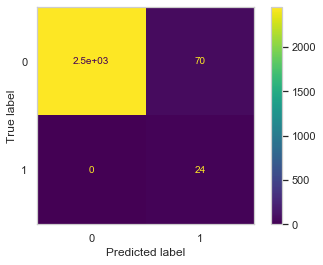

In [14]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

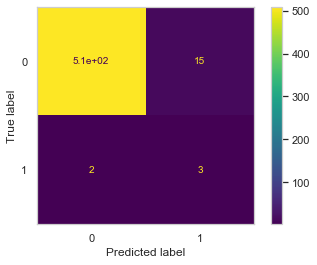

In [15]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [16]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([1.14158054e-04, 8.22751783e-05, 1.14522711e-04, 1.99763035e-04,
       6.43861330e-05])

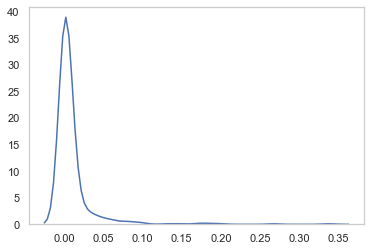

In [17]:
sns.kdeplot(y_pred);

In [18]:
metrics.confusion_matrix(y_test, y_pred > 0.03)

array([[482,  42],
       [  0,   5]])

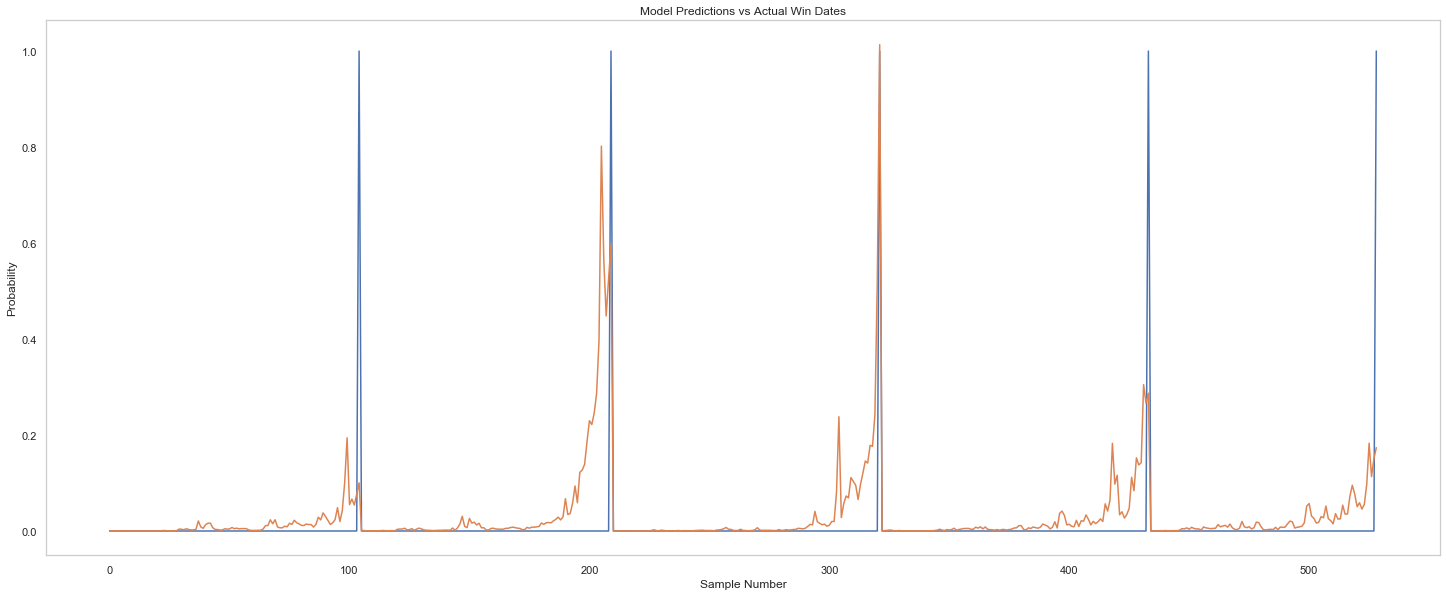

In [19]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(3*y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

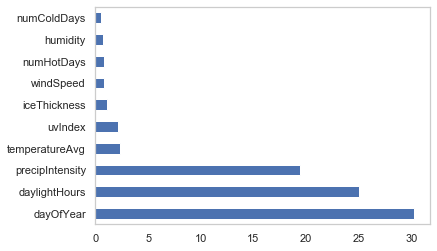

In [20]:
pd.Series(abs(clf_svc.coef_[0]), index=train[svc_no_ma_cols].columns).nlargest(10).plot(kind='barh');

In [21]:
# svm_best_cols = ['daylightHours', 'precipIntensity', 'dayOfYear', 'temperatureAvg', 'accumulatedSnow',
#                  'iceThickness', 'numColdDays']
# after river flow data added
svm_best_cols = ['dayOfYear', 'daylightHours', 'temperatureAvg', 'accumulatedSnow',
                 'iceThickness', 'flowVolume', 'numColdDays']

---
#### Support Vector Machine Classifier Model Using Top Features From Baseline Excluding Moving Average Features Model

In [22]:
target = 'winningDate'

scaler = RobustScaler()

clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)

pipe = make_pipeline(scaler, clf_svc)

X_train, y_train = train[svm_best_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted',
                                 'accuracy', 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: 0.9665486683087183 +/- 0.013847494503574144
precision_weighted: 0.9896346268830143 +/- 0.0033967033355567
recall_weighted: 0.9485849056603775 +/- 0.023977858541771386
accuracy: 0.9485849056603775 +/- 0.023977858541771386
roc_auc: 0.9582142857142857 +/- 0.053858227011108026


In [23]:
pipe.fit(X_train, y_train)
X_test = test[svm_best_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [24]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.947069943289225


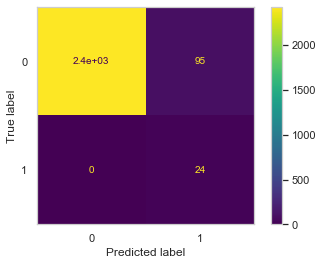

In [25]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

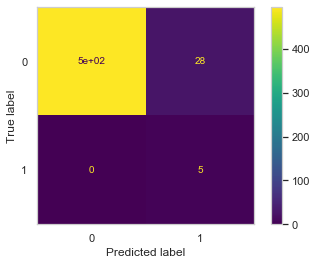

In [26]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [27]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.00103333, 0.00114693, 0.00119144, 0.00133518, 0.00115603])

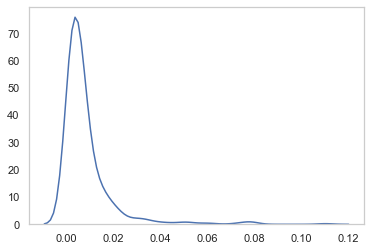

In [28]:
sns.kdeplot(y_pred);

In [29]:
metrics.confusion_matrix(y_test, y_pred > 0.04)

array([[514,  10],
       [  1,   4]])

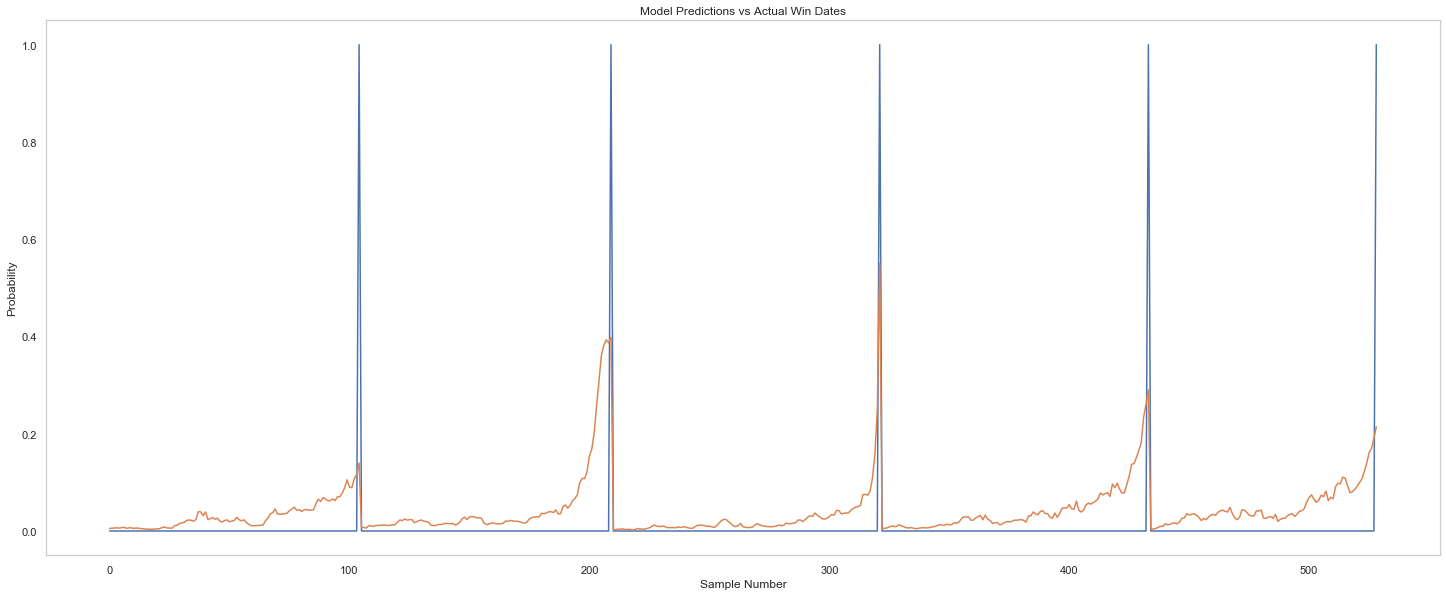

In [30]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(5*y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Removed all models using moving average features
They were too resource-intensive for my laptop, and the base features the moving averages were derived from were enough for reasonably adequate performance.